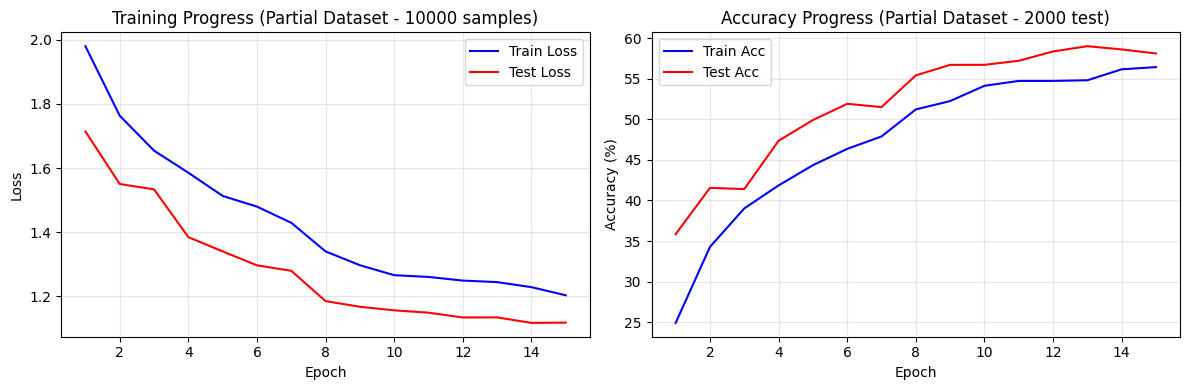

Epoch 15/15
Train Acc: 56.42%
Test Acc: 58.10%

🎊 TRAINING COMPLETE!
Dataset used: 10,000 train, 2,000 test samples
Percentage of full dataset: 20.0%
Total time: 1.4 minutes
Best test accuracy: 59.00%
Final test accuracy: 58.10%


In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
import time
import os
import numpy as np
from collections import defaultdict

# CONFIGURATION - MODIFY THESE VALUES

# Dataset configuration
USE_EXACT_SAMPLES = False  # Set to True to use exact sample counts
DATASET_FRACTION = 0.2     # Use 20% of dataset (when USE_EXACT_SAMPLES = False)
TRAIN_SAMPLES = 5000       # Exact training samples (when USE_EXACT_SAMPLES = True)
TEST_SAMPLES = 1000        # Exact test samples (when USE_EXACT_SAMPLES = True)

# Training configuration
BATCH_SIZE = 64
NUM_WORKERS = 2
EPOCHS = 15
LEARNING_RATE = 0.001
DROPOUT_RATE = 0.3

# SETUP AND DEVICE CHECK

print("🔍 Checking GPU availability...")
if torch.cuda.is_available():
    print(f"✅ GPU found: {torch.cuda.get_device_name(0)}")
    print(f"💾 VRAM: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
    device = torch.device('cuda')
else:
    print("❌ No GPU found - using CPU")
    device = torch.device('cpu')

# Create model directory
model_dir = '/content/cifar10_models'
os.makedirs(model_dir, exist_ok=True)

print(f"\n Dataset Configuration:")
if USE_EXACT_SAMPLES:
    print(f"Using exact samples - Train: {TRAIN_SAMPLES:,}, Test: {TEST_SAMPLES:,}")
else:
    print(f"Using {DATASET_FRACTION*100:.1f}% of dataset")

print(f"\n⚙️ Training Settings:")
print(f"Batch size: {BATCH_SIZE}")
print(f"Epochs: {EPOCHS}")
print(f"Learning rate: {LEARNING_RATE}")

# DATA TRANSFORMS


transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# DATASET SUBSET CREATION (FIXED)

def create_balanced_subset(dataset, num_samples, num_classes=10):
    """Create a balanced subset with equal samples per class"""
    # Get all labels
    if hasattr(dataset, 'targets'):
        targets = np.array(dataset.targets)
    else:
        targets = np.array([dataset[i][1] for i in range(len(dataset))])

    # Calculate samples per class
    samples_per_class = num_samples // num_classes
    remainder = num_samples % num_classes

    indices = []
    for class_idx in range(num_classes):
        class_indices = np.where(targets == class_idx)[0]

        # Add extra sample for some classes if there's remainder
        class_samples = samples_per_class + (1 if class_idx < remainder else 0)

        # Randomly select indices for this class
        selected_indices = np.random.choice(class_indices,
                                          min(class_samples, len(class_indices)),
                                          replace=False)
        indices.extend(selected_indices.tolist())  # Convert to list

    return indices

def check_class_distribution(subset, dataset_name):
    """Check the distribution of classes in the subset"""
    if hasattr(subset.dataset, 'targets'):
        all_targets = np.array(subset.dataset.targets)
    else:
        all_targets = np.array([subset.dataset[i][1] for i in range(len(subset.dataset))])

    subset_targets = all_targets[subset.indices]
    unique, counts = np.unique(subset_targets, return_counts=True)

    print(f"\n📋 {dataset_name} class distribution:")
    class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    for class_idx, count in zip(unique, counts):
        print(f"  {class_names[class_idx]}: {count} samples")

# Load full dataset
print("\n📥 Loading CIFAR-10 dataset...")
full_trainset = CIFAR10(root='/content/data', train=True, download=True, transform=transform_train)
full_testset = CIFAR10(root='/content/data', train=False, download=True, transform=transform_test)

# Create subsets
print("\n🎲 Creating dataset subsets...")
np.random.seed(42)  # For reproducibility

if USE_EXACT_SAMPLES:
    train_size = TRAIN_SAMPLES
    test_size = TEST_SAMPLES
else:
    train_size = int(len(full_trainset) * DATASET_FRACTION)
    test_size = int(len(full_testset) * DATASET_FRACTION)

# Create balanced subsets
print("Creating balanced training subset...")
train_indices = create_balanced_subset(full_trainset, train_size)
trainset = Subset(full_trainset, train_indices)

print("Creating balanced test subset...")
test_indices = create_balanced_subset(full_testset, test_size)
testset = Subset(full_testset, test_indices)

# Create data loaders
train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True,
                         num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=NUM_WORKERS, pin_memory=True)

print(f" Subset created - Train: {len(trainset):,}, Test: {len(testset):,}")
print(f"Original dataset - Train: {len(full_trainset):,}, Test: {len(full_testset):,}")
print(f" Using {len(trainset)/len(full_trainset)*100:.1f}% of training data")

# Show class distributions
check_class_distribution(trainset, "Training")
check_class_distribution(testset, "Test")


# CNN MODEL DEFINITION

class CIFAR10CNN(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(CIFAR10CNN, self).__init__()

        # Convolutional layers with batch normalization
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)

        self.conv5 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)

        self.conv6 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn6 = nn.BatchNorm2d(128)

        # Pooling and dropout
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout2d(dropout_rate)
        self.dropout_fc = nn.Dropout(dropout_rate)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        # Block 1: 32x32 -> 16x16
        x = self.pool(F.relu(self.bn2(self.conv2(F.relu(self.bn1(self.conv1(x)))))))
        x = self.dropout(x)

        # Block 2: 16x16 -> 8x8
        x = self.pool(F.relu(self.bn4(self.conv4(F.relu(self.bn3(self.conv3(x)))))))
        x = self.dropout(x)

        # Block 3: 8x8 -> 4x4
        x = self.pool(F.relu(self.bn6(self.conv6(F.relu(self.bn5(self.conv5(x)))))))
        x = self.dropout(x)

        # Flatten and fully connected layers
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)
        x = F.relu(self.fc2(x))
        x = self.dropout_fc(x)
        x = self.fc3(x)

        return x

# MODEL INITIALIZATION

print("\n🏗️ Initializing model...")
model = CIFAR10CNN(dropout_rate=DROPOUT_RATE).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

total_params = sum(p.numel() for p in model.parameters())
print(f"📊 Total parameters: {total_params:,}")


# TRAINING FUNCTIONS

def plot_progress(history, epoch):
    """Plot training progress"""
    try:
        from IPython.display import clear_output
        clear_output(wait=True)
    except:
        pass

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    epochs = range(1, len(history['train_loss']) + 1)

    # Loss plot
    ax1.plot(epochs, history['train_loss'], 'b-', label='Train Loss')
    ax1.plot(epochs, history['test_loss'], 'r-', label='Test Loss')
    ax1.set_title(f'Training Progress (Partial Dataset - {len(trainset)} samples)')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Accuracy plot
    ax2.plot(epochs, history['train_acc'], 'b-', label='Train Acc')
    ax2.plot(epochs, history['test_acc'], 'r-', label='Test Acc')
    ax2.set_title(f'Accuracy Progress (Partial Dataset - {len(testset)} test)')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"Epoch {epoch}/{EPOCHS}")
    print(f"Train Acc: {history['train_acc'][-1]:.2f}%")
    print(f"Test Acc: {history['test_acc'][-1]:.2f}%")

def save_checkpoint(model, optimizer, epoch, history, filename):
    """Save model checkpoint"""
    try:
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'history': history,
            'dataset_info': {
                'train_size': len(trainset),
                'test_size': len(testset),
                'use_exact_samples': USE_EXACT_SAMPLES,
                'fraction': DATASET_FRACTION if not USE_EXACT_SAMPLES else 'exact'
            }
        }
        filepath = f"{model_dir}/{filename}"
        torch.save(checkpoint, filepath)
        print(f"💾 Checkpoint saved: {filename}")
    except Exception as e:
        print(f"⚠️ Could not save checkpoint: {e}")

def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

        # Print progress for smaller datasets
        if len(train_loader) <= 50:  # If very small dataset
            print_freq = max(1, len(train_loader) // 5)
        else:
            print_freq = max(1, len(train_loader) // 3)

        if batch_idx % print_freq == 0:
            print(f'Batch {batch_idx:3d}/{len(train_loader)}: '
                  f'Loss: {loss.item():.4f}, '
                  f'Acc: {100.*correct/total:.2f}%')

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def validate_epoch(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()

            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

    test_loss /= len(test_loader)
    test_acc = 100. * correct / total
    return test_loss, test_acc

# MAIN TRAINING FUNCTION


def train_model():
    print("\n Starting training on partial dataset...")
    print("=" * 60)

    history = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': []
    }

    best_acc = 0.0
    start_time = time.time()

    for epoch in range(EPOCHS):
        epoch_start = time.time()
        print(f"\nEpoch {epoch+1}/{EPOCHS}")
        print("-" * 30)

        # Training
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

        # Validation
        test_loss, test_acc = validate_epoch(model, test_loader, criterion, device)

        # Update learning rate
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']

        # Record history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)

        # Calculate epoch time
        epoch_time = time.time() - epoch_start

        # Print summary
        print(f"\nEpoch {epoch+1} Summary:")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Test Loss:  {test_loss:.4f}, Test Acc:  {test_acc:.2f}%")
        print(f"Learning Rate: {current_lr:.6f}")
        print(f"Time: {epoch_time:.1f}s")

        # Save best model
        if test_acc > best_acc:
            best_acc = test_acc
            save_checkpoint(model, optimizer, epoch+1, history, 'best_model_partial.pth')
            print(f"🎉 New best accuracy: {best_acc:.2f}%")

        # Save checkpoint every 5 epochs
        if (epoch + 1) % 5 == 0:
            save_checkpoint(model, optimizer, epoch+1, history,
                           f'checkpoint_partial_epoch_{epoch+1}.pth')

        # Plot progress
        plot_progress(history, epoch+1)

        # ETA calculation
        elapsed = time.time() - start_time
        avg_epoch_time = elapsed / (epoch + 1)
        remaining_epochs = EPOCHS - (epoch + 1)
        eta = remaining_epochs * avg_epoch_time

        if remaining_epochs > 0:
            print(f"⏱️ ETA: {eta/60:.1f} minutes")

    # Final summary
    total_time = time.time() - start_time
    print("\n" + "=" * 60)
    print("TRAINING COMPLETE!")
    print(f"Dataset used: {len(trainset):,} train, {len(testset):,} test samples")
    print(f"Percentage of full dataset: {len(trainset)/len(full_trainset)*100:.1f}%")
    print(f"Total time: {total_time/60:.1f} minutes")
    print(f"Best test accuracy: {best_acc:.2f}%")
    print(f"Final test accuracy: {history['test_acc'][-1]:.2f}%")

    return history

# =====================================================================
# READY TO TRAIN
# =====================================================================

print("\n Setup complete! Ready to train on partial dataset!")
print(f" Training with {len(trainset):,} samples ({len(trainset)/len(full_trainset)*100:.1f}% of full dataset)")
print("\n To start training, run:")
print("history = train_model()")

print("\n Quick configuration changes:")
print("• For 10% dataset: DATASET_FRACTION = 0.1")
print("• For 5% dataset: DATASET_FRACTION = 0.05")
print("• For exact samples: USE_EXACT_SAMPLES = True")

history = train_model()